# Create and analyse a source catalog with Megacam photometry informations in the 5 color bands and references from a subset of the SDSS DR9 catalog

#### The first 2 blocks of this ipython notebook correspond to the catalog creation which requires access to CFHT images reduced with the LSST stack (calibrated exposure or calexp).  A prepared catalog is available at : http://www.slac.stanford.edu/~boutigny/CFHT/photometry.pickle it contains > 40 000 associated sources from g and r exposures corresponding to the D3 CFHT field.

Updates :
<UL>
    <LI> 3/17/2015 : New catalog produced with an updated obs_cfht where the CCD saturation levels are computed from the pixel values. In previous version the saturated stars ere not correcltly detected
</UL>

## Catalog creation

<OL>
<LI> A source catalog is chosen as a reference (g band) 
<LI> We match it to every other catalogs (r, i, u and z)
<LI> The result of the first match (g/r) is chosen as a reference match
<LI> We compare every other match to the reference match in order to find common sources
<LI> We also find sources in the reference match which are also in an external catalog (SDSS)
</OL>


In [1]:
from lsst.meas.astrom import Astrometry
import lsst.daf.persistence as dafPersist
import lsst.afw.cameraGeom as cg
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import math

def getMagnitude(butler, mRef, visit, filter) :
    # Compute the magnitude associated to a given object mRef
    
    # retrieve the CCD corresponding to the reference source
    ccdRef = mRef.get('ccd')
    # retrieve the calibration object associated to the CCD
    did = {'visit':visit, 'filter':filter, 'ccd':ccdRef}
    md = butler.get("calexp_md", did, immediate=True)
    calib = afwImage.Calib(md)
    # compute magnitude
    flux = mRef.get('base_SincFlux_flux')
    if flux >= 0. :
        return calib.getMagnitude(flux, mRef.get('base_SincFlux_fluxSigma'))
    else :
        return 999.0

def createFullFPCatalog(butler, visit, filter) :
    # Cretae a big table containing the sources found in every CCD
    # Keep the CCD number associated to each source in order to be able to retrieve the proper calibration object
    for ccd in range(36) :
        dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}
        oldSrc = butler.get('src', dataid, immediate=True)
#        print ccd, len(oldSrc)
        if ccd == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type=int, doc="CCD number")
            
            #create the new extented source catalog 
            srcRef = afwTable.SourceCatalog(newSchema)
        
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = ccd
        # append the temporary catalog to the extended source catalog    
        srcRef.extend(tmpCat, deep=False)
    
    return srcRef

def mkmag(flux):
    return -2.5*math.log(flux)/math.log(10.)

# We choose g filter as a reference to which every catalog will be compared to
visit_ref = 918231
filter_ref = "g"
visits  = [906675, 832860, 906805, 845355]
filters = ["r", "i", "u", "z"]

# List of flags used to reject suspicious sources
Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge"]

#setup butler
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

#setup astrometry solver
solve = Astrometry.ConfigClass()
astrom = Astrometry(solve)

# setup camera and get the astrometry catalog corresponding to the region of interest
cam = butler.get('camera')
ccd14 = cam['ccd14']
vId = {'visit':visits[0], 'ccd':14}
calexp = butler.get("calexp", vId, immediate=True)
detCenter = ccd14.getCenter(cg.PIXELS).getPoint()
detCenterCoord = calexp.getWcs().pixelToSky(detCenter)

# Retrieve the external astrometry catalog corresponding to the ROI and to the refrence filter
astrom_ref = astrom.getReferenceSources(detCenterCoord.getLongitude(), detCenterCoord.getLatitude(), 
                                        afwGeom.Angle(1., afwGeom.degrees), filter_ref)

# Assemble all CCD in one big afw table extended in such a way to keep track of the CCD number

# First for the reference filter
src_ref = createFullFPCatalog(butler, visit_ref, filter_ref)

#Then for the 4 other filters
src = []
for i in range(4) :
    src.append(createFullFPCatalog(butler, visits[i], filters[i]))
    print("Found %d sources in visit %d for filter %s" %(len(src[i]), visits[i], filters[i]))

# Match the reference filter with the external catalog
match_ref = afwTable.matchRaDec(astrom_ref, src_ref, afwGeom.Angle(1./3600., afwGeom.degrees))
print("Found %d astrometric reference matches for filter %s" %(len(match_ref), filter_ref))

# Match every source catalogs to the filter taken as an internal reference (g)
match_src = []
src_id = []
for i in range(4) :
    match_src.append(afwTable.matchRaDec(src_ref, src[i], afwGeom.Angle(1./3600., afwGeom.degrees)))
    print("Found %d %s - %s matches" %(len(match_src[i]), filter_ref, filters[i]))
    # Build lists of reference source Id for each match
    src_id.append([])
    for m in match_src[i] :
        src_id[i].append(m.first.getId())
        
# Also record the reference source Id for each positive match to the external astrometry catalog
src_id_ref = []
for m in match_ref :
    src_id_ref.append(m.second.getId())

# Iterate over each entry in the first matched catalog and check if the reference source is present
# in other matched catalog. If yes, record the index location of each match

print "Finding the overlap between the matched catalogs"
check = []
for cnts,id in enumerate(src_id[0]) :
    if float(cnts)//5000 == float(cnts)/5000 :
        print cnts
    temp = []
    # First check the overlap between the filters
    for i in (1, 2, 3) :
        try :
            temp.append(src_id[i].index(id))
        except :
            temp.append(-1) 
    # Then the external astrometry catalog
    try :
        temp.append(src_id_ref.index(id))
    except :
        temp.append(-1)
        
    check.append(temp)

Found 67980 sources in visit 906675 for filter r
Found 62516 sources in visit 832860 for filter i
Found 52576 sources in visit 906805 for filter u
Found 43628 sources in visit 845355 for filter z
Found 2356 astrometric reference matches for filter g
Found 42260 g - r matches
Found 37597 g - i matches
Found 32670 g - u matches
Found 24557 g - z matches
Finding the overlap between the matched catalogs
0
5000
10000
15000
20000
25000
30000
35000
40000


<OL>
<LI> We iterate over all the reference matches (g <--> r) and retrieve relevant informations associated to each filter also matched to g
<LI> We also get the informations from the external reference catalog when available
<LI> If no match is found, we write "-1" in place of the missing informations
<LI> All the relevant informations is persisted in a pickle file
</OL>

The format of the records in the pickle file is the following :<BR>
[Ra, Dec, source_extendedness {filter: [mag, err_mag, snr, ccd, ref_flux, ref_err_flux]} {"ref": [distance, photometric]}]
<UL>
<LI> Ra, Dec : source coordinates measured in the g filter image
<LI> source_extendedness : star / galaxy selector (0 = star - 1 = galaxy)
<LI> filter : keyword to select the informations corresponding to a given filter : g, r, i, u, z
<LI> mag : magnitude
<LI> err_mag : error on magnitude
<LI> snr : signal / noise ratio
<LI> ccd : the ccd number in which the source has been detected (0-35)
<LI> ref_flux : the flux of the source in the external reference catalog
<LI> ref_err_flux : the error on the flux of the source in the external reference catalog
</UL>
The "ref" keyword allows to access global informations (common to every filter) for sources in the external reference catalog
<UL>
<LI> distance : angular distance in radians between the source and and the reference in the external catalog
<LI> photometric : True if the photometric information of the source in the external catalog is reliable ( I guess !)
</UL>

In [2]:
import cPickle as pickle

def getMagnitude(butler, mRef, visit, filter) :
    # Compute the magnitude associated to a given object mRef
    
    # retrieve the CCD corresponding to the reference source
    ccdRef = mRef.get('ccd')
    # retrieve the calibration object associated to the CCD
    did = {'visit':visit, 'filter':filter, 'ccd':ccdRef}
    md = butler.get("calexp_md", did, immediate=True)
    calib = afwImage.Calib(md)
    # compute magnitude
    flux = mRef.get('base_SincFlux_flux')
    if flux >= 0. :
        return calib.getMagnitude(flux, mRef.get('base_SincFlux_fluxSigma'))
    else :
        return 999.0, 999.0

fileName = '../photometry_March16_2015.pickle'
file = open(fileName,'wb')
    
record = []
for cnts,ck in enumerate(check) :
    if float(cnts)//5000 == float(cnts)/5000 :
        print cnts
#    if cnts > 200 :
#        break
    ref_match = match_src[0][cnts]
    ref_0 = ref_match.first
    ref_1 = ref_match.second
    
    # Do not consider sources with bad flags
    # Would be more efficient to do it before matching the catalogs
    for f in Flags :
        rej = 0
        if ref_0.get(f) or ref_1.get(f) :
            rej = 1
            break
    if rej == 1 :
        continue

    # Do not consider sources with snr(g) < 5 sigma
    signalToNoise = ref_0.get("base_SincFlux_flux")/ref_0.get("base_SincFlux_fluxSigma")
    if signalToNoise < 5.0 :
        continue
            
    # Output record
    record = []
    record.append(ref_0.getRa().asRadians())
    record.append(ref_0.getDec().asRadians())
    record.append(ref_0.get("base_ClassificationExtendedness_value"))
    
    # Prepare data structure using a dictionary with the filter as a single key
    field = {filter_ref:[], filters[0]:[], filters[1]:[], filters[2]:[], filters[3]:[], "ref":[]}
    
    # mag_g, emag_g, s/n_g
    field[filter_ref].extend(getMagnitude(butler,ref_0,visit_ref,filter_ref))
    field[filter_ref].append(signalToNoise)
    field[filter_ref].append(ref_0.get("ccd"))
    # mag_r, emag_r, s/n_r
    field[filters[0]].extend(getMagnitude(butler,ref_1,visits[0],filters[0]))
    field[filters[0]].append(ref_1.get("base_SincFlux_flux")/ref_1.get("base_SincFlux_fluxSigma"))
    field[filters[0]].append(ref_1.get("ccd"))
        
    for i in range(3) :
        ind = ck[i]
        if ind != -1 :
            ref_match = match_src[i+1][ind]
            ref_filt = ref_match.second
            # check for bad flags
            for f in Flags :
                rej = 0
                if ref_filt.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                field[filters[i+1]].extend([-2, -2, -2, -2])
            else :
                field[filters[i+1]].extend(getMagnitude(butler,ref_filt,visits[i+1],filters[i+1]))
                field[filters[i+1]].append(ref_filt.get("base_SincFlux_flux")/ref_filt.get("base_SincFlux_fluxSigma"))
                field[filters[i+1]].append(ref_filt.get("ccd"))
        else :
            field[filters[i+1]].extend([-1, -1, -1, -1])
    
    ind = ck[3]
    if ind != -1 :
        ref_match = match_ref[ind]
        ref_m = ref_match.first
        field["ref"].append(ref_match.distance)
        field["ref"].append(ref_m.get("photometric"))
        field[filter_ref].append(ref_m.get(filter_ref))
        field[filter_ref].append(ref_m.get(filter_ref+".err"))
        for f in range(4) :
            field[filters[f]].append(ref_m.get(filters[f]))
            field[filters[f]].append(ref_m.get(filters[f]+".err"))  
    else :
        field["ref"].extend([-1, -1])
        field[filter_ref].extend([-1, -1])
        for i in range(4) :
            field[filters[i]].extend([-1, -1])
    
#    print field["g"]        
    record.append(field)   
#    print record
    pickle.dump(record, file)
#    print record[3]["ref"]  
    
file.close()
        
    

0
5000
10000
15000
20000
25000
30000
35000
40000


## Catalog analysis

#### The following blocks demonstrate how to read the catalog and run analysis on the stored quantities 

### Color diagrams

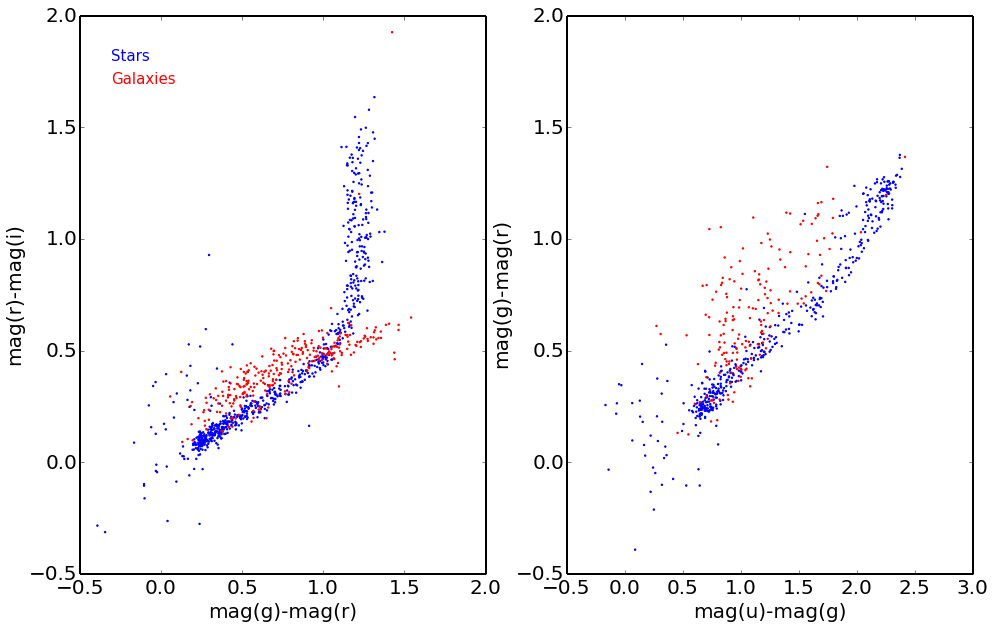

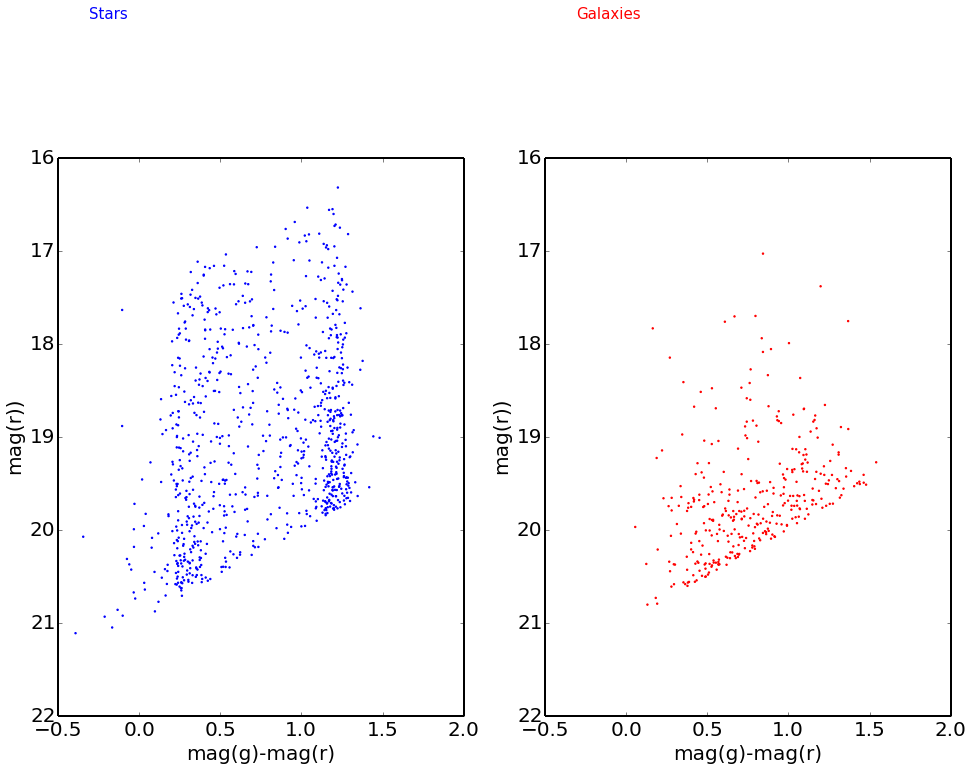

In [8]:
%matplotlib inline
import cPickle as pickle
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

fileName = '../photometry_March16_2015.pickle'
file = open(fileName,'rb')

g_rS = []
r_iS = []
g_rG = []
r_iG = []

g_rS2 = []
g_rG2 = []
u_gS = []
u_gG = []

g_rS3 = []
g_rG3 = []

rS = []
rG = []

while True :
    try :
        record = pickle.load(file)
    except :
        break
        
    mag_g = record[3]["g"][0]
    snr_g = record[3]["g"][2]
    mag_r = record[3]["r"][0]
    snr_r = record[3]["r"][2]
    mag_i = record[3]["i"][0]
    snr_i = record[3]["i"][2]
    mag_u = record[3]["u"][0]
    snr_u = record[3]["u"][2]
        
    if mag_g < 21 and mag_i > 0 and snr_g > 5 and snr_r > 5 and snr_i > 5 :
        if record[2] < 0.5 :
            g_rS.append(mag_g-mag_r)
            r_iS.append(mag_r-mag_i)
        else :
            g_rG.append(mag_g-mag_r)
            r_iG.append(mag_r-mag_i)
            
    if mag_g < 21 and mag_u > 0 and mag_u < 22 and mag_r > 0 and snr_g > 5 and snr_r > 5 and snr_u > 5 :
        if record[2] < 0.5 :
            g_rS2.append(mag_g-mag_r)
            u_gS.append(mag_u-mag_g)
        else :
            g_rG2.append(mag_g-mag_r)
            u_gG.append(mag_u-mag_g)
            
    if mag_g < 21 and mag_r > 0 and snr_g > 5 and snr_r > 5 :
        if record[2] < 0.5 :
            g_rS3.append(mag_g-mag_r)
            rS.append(mag_r)
        else :
            g_rG3.append(mag_g-mag_r)
            rG.append(mag_r)
            
file.close()

plt.clf()
plt.rcParams['axes.linewidth'] = 2 #set the value globally
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,10))
ax0.scatter(g_rS, r_iS, s=2., color='b')
ax0.scatter(g_rG, r_iG, s=2., color='r')
ax0.set_xlim([-0.5,2.0])
ax0.set_ylim([-0.5,2.0])
ax0.set_xlabel("mag(g)-mag(r)", fontsize=20, weight='normal')
ax0.set_ylabel("mag(r)-mag(i)", fontsize=20, weight='normal')
ax0.tick_params(labelsize=20)
ax0.text(-0.3, 1.8, 'Stars', color='b', fontsize=15)
ax0.text(-0.3, 1.7, 'Galaxies', color='r', fontsize=15)

ax1.scatter(u_gS, g_rS2, s=2., color='b')
ax1.scatter(u_gG, g_rG2, s=2., color='r')
ax1.set_xlim([-0.5,3.0])
ax1.set_ylim([-0.5,2.0])
ax1.set_xlabel("mag(u)-mag(g)", fontsize=20, weight='normal')
ax1.set_ylabel("mag(g)-mag(r)", fontsize=20, weight='normal')
ax1.tick_params(labelsize=20)

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(16,10))
ax2.scatter(g_rS3, rS, s=2., color='b')
ax2.set_xlabel("mag(g)-mag(r)", fontsize=20, weight='normal')
ax2.set_ylabel("mag(r))", fontsize=20, weight='normal')
ax2.tick_params(labelsize=20)
ax2.set_xlim([-0.5,2.0])
ax2.set_ylim([22,16])
ax2.text(-0.3, 14.5, 'Stars', color='b', fontsize=15)

ax3.scatter(g_rG3, rG, s=2., color='r')
ax3.set_xlabel("mag(g)-mag(r)", fontsize=20, weight='normal')
ax3.set_ylabel("mag(r))", fontsize=20, weight='normal')
ax3.tick_params(labelsize=20)
ax3.set_xlim([-0.5,2.0])
ax3.set_ylim([22,16])
ax3.text(-0.3, 14.5, 'Galaxies', color='r', fontsize=15)


### Error on magnitude versus magnitude for each filter

Large error 35 0.146951595883
Large error 35 0.146953999754
Large error 35 0.146952592976
Large error 35 0.14695373569
Large error 11 0.123929452919
Large error 11 0.123895161288
Large error 11 0.123924931368
Large error 11 0.123982099821
Large error 11 0.123893171023
Large error 11 0.123973996113
Large error 11 0.123949775763
Large error 11 0.12391316524
Large error 11 0.123975673768
Large error 11 0.123917766681
Large error 11 0.123966073684
Large error 11 0.123927505357
Large error 11 0.123954429905
Large error 11 0.123920952572
Large error 11 0.123896330368


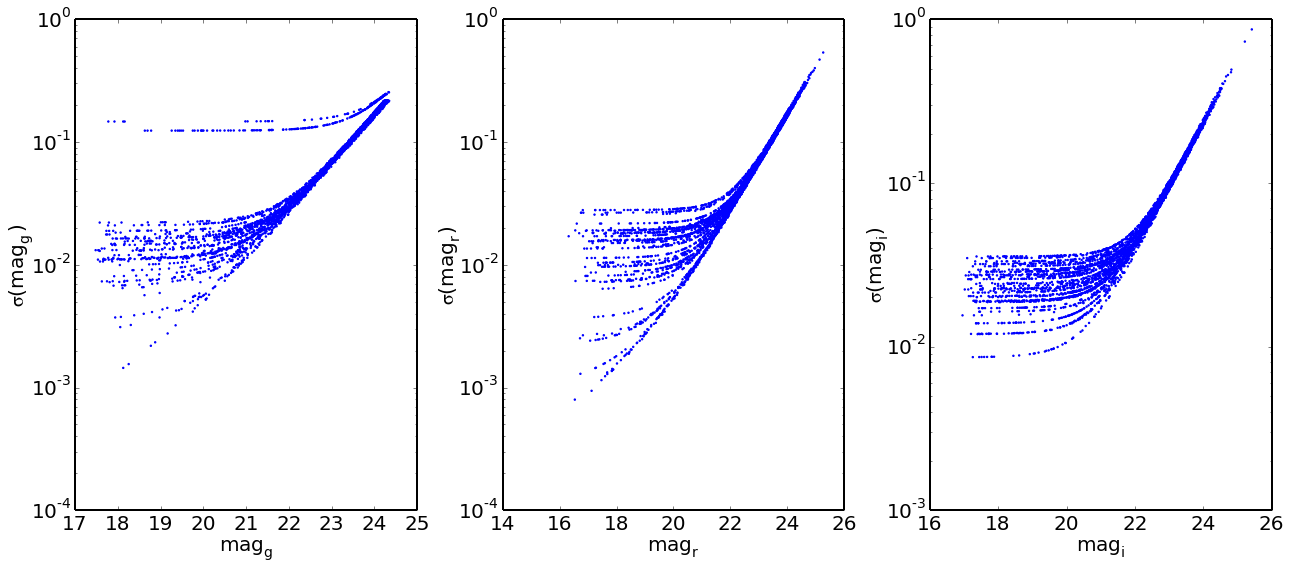

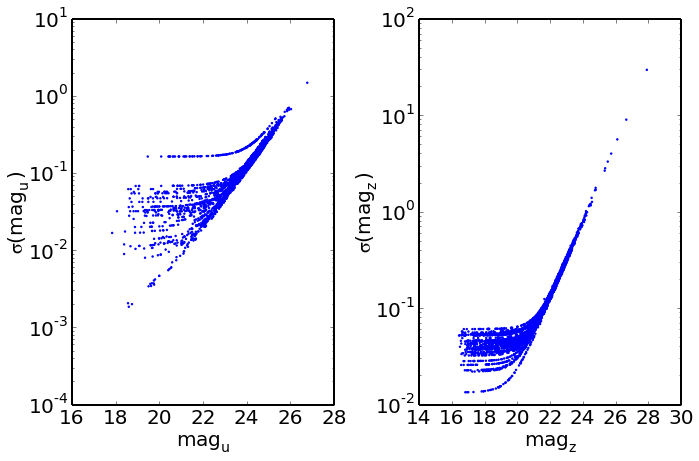

In [2]:
%matplotlib inline
import cPickle as pickle
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

fileName = '../photometry_March16_2015.pickle'
file = open(fileName,'rb')

g = []
r = []
i = []
u = []
z = []
sigma_g = []
sigma_r = []
sigma_i = []
sigma_u = []
sigma_z = []

while True :
    try :
        record = pickle.load(file)
    except :
        break
        
        
    if record[2] > 0.5 :
        continue
        
    mag_g = record[3]["g"][0]
    mag_r = record[3]["r"][0]
    mag_i = record[3]["i"][0]
    mag_u = record[3]["u"][0]
    mag_z = record[3]["z"][0]
  
    if mag_g <100 and mag_g > 0 :
        g.append(mag_g)
        sigma_g.append(record[3]["g"][1])
        if record[3]["g"][1] > 0.1 and mag_g < 20 :
            print "Large error", record[3]["g"][3], record[3]["g"][1]
    if mag_r <100 and mag_r > 0 :
        r.append(mag_r)
        sigma_r.append(record[3]["r"][1])
    if mag_i <100 and mag_i > 0 :
        i.append(mag_i)
        sigma_i.append(record[3]["i"][1])
    if mag_u <100 and mag_u > 0 :
        u.append(mag_u)
        sigma_u.append(record[3]["u"][1])
    if mag_z <100 and mag_z > 0 and record[3]["z"][1] < 100 :
        z.append(mag_z)
        sigma_z.append(record[3]["z"][1])
    
file.close()

plt.clf()
#plt global parameters
plt.rcParams['axes.linewidth'] = 2 
plt.rcParams['mathtext.default'] = 'regular'

fig, (ax) = plt.subplots(ncols=3, figsize=(18,8))
ax[0].scatter(g, sigma_g, s=2, color='b')
ax[0].set_xlabel("$mag_g$", fontsize=20, weight='normal')
ax[0].set_ylabel("$\sigma(mag_g)$", fontsize=20, weight='normal', labelpad=-5)
ax[0].tick_params(labelsize=20)
ax[0].set_yscale('log')

ax[1].scatter(r, sigma_r, s=2, color='b')
ax[1].set_xlabel("$mag_r$", fontsize=20, weight='normal')
ax[1].set_ylabel("$\sigma(mag_r)$", fontsize=20, weight='normal', labelpad=-5)
ax[1].tick_params(labelsize=20)
ax[1].set_ylim([1e-4,1])
ax[1].set_yscale('log')

ax[2].scatter(i, sigma_i, s=2, color='b')
ax[2].set_xlabel("$mag_i$", fontsize=20, weight='normal')
ax[2].set_ylabel("$\sigma(mag_i)$", fontsize=20, weight='normal', labelpad=-5)
ax[2].tick_params(labelsize=20)
ax[2].set_yscale('log')
fig.tight_layout()

fig, (ay) = plt.subplots(ncols=2, figsize=(9.8,6.5))
ay[0].scatter(u, sigma_u, s=2, color='b')
ay[0].set_xlabel("$mag_u$", fontsize=20, weight='normal')
ay[0].set_ylabel("$\sigma(mag_u)$", fontsize=20, weight='normal', labelpad=-5)
ay[0].tick_params(labelsize=20)
ay[0].set_yscale('log')

ay[1].scatter(z, sigma_z, s=2, color='b')
ay[1].set_xlabel("$mag_z$", fontsize=20, weight='normal')
ay[1].set_ylabel("$\sigma(mag_z)$", fontsize=20, weight='normal', labelpad=-5)
ay[1].tick_params(labelsize=20)
ay[1].set_yscale('log')
fig.tight_layout()

Each band in the above plots corresponds to a different ccd

### Plot magnitudes for each filter

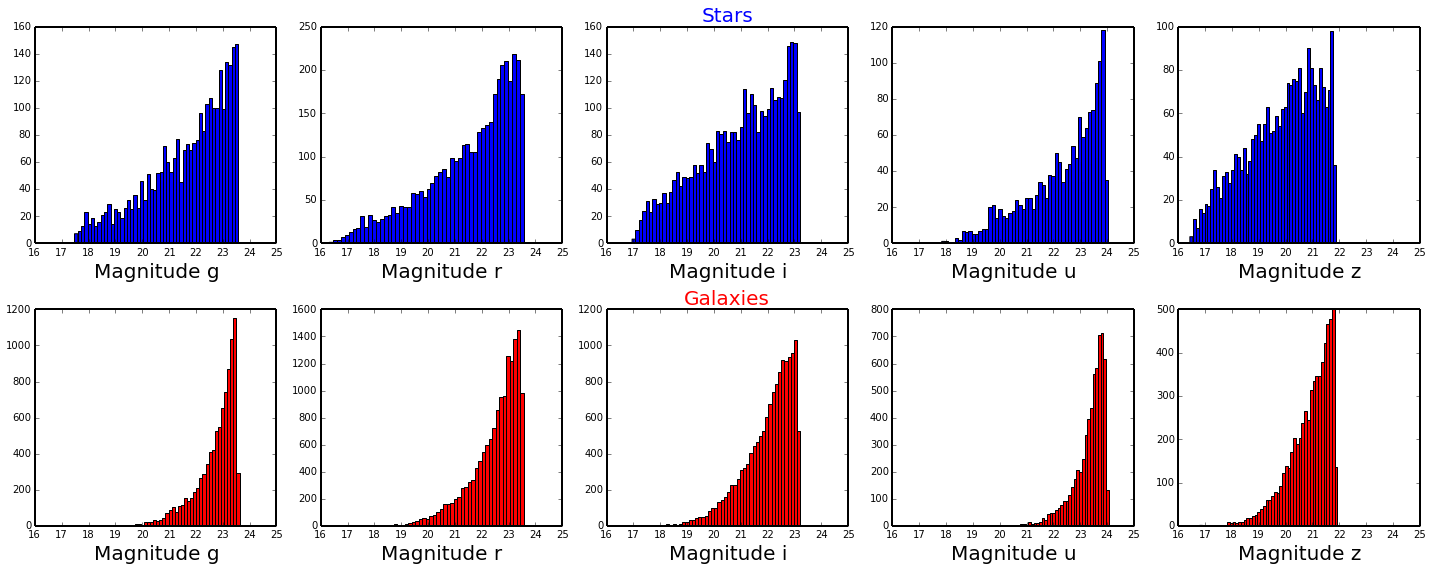

In [7]:
%matplotlib inline
import cPickle as pickle
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

fileName = '../photometry_March16_2015.pickle'
file = open(fileName,'rb')

filters = ["g", "r", "i", "u", "z"]
magS = {"g":[], "r":[], "i":[], "u":[], "z":[]}
magG = {"g":[], "r":[], "i":[], "u":[], "z":[]}

while True :
    try :
        record = pickle.load(file)
    except :
        break
        
    for f in filters :
        mag = record[3][f][0]
        snr = record[3][f][2]
        if mag > 0 and mag < 100 and snr > 10 :
            if record[2] < 0.5 :
                magS[f].append(mag)
            else :
                magG[f].append(mag)
    
file.close()

plt.clf()
#plt global parameters
plt.rcParams['axes.linewidth'] = 2 
plt.rcParams['mathtext.default'] = 'regular'

fig, (ax) = plt.subplots(ncols=5, nrows=2, figsize=(20,8))
for cnts,f in enumerate(filters) :
    ax[0][cnts].hist(magS[f], color='b', histtype='bar', bins=50)
    ax[0][cnts].set_xlabel("Magnitude "+f, fontsize=20, weight='normal')
    ax[0][cnts].tick_params(labelsize=10)
    ax[0][cnts].set_xlim([16,25])
#    ax[0][cnts].set_yscale('log')
    ax[1][cnts].hist(magG[f], color='r', histtype='bar', bins=50)
    ax[1][cnts].set_xlabel("Magnitude "+f, fontsize=20, weight='normal')
    ax[1][cnts].tick_params(labelsize=10)
    ax[1][cnts].set_xlim([16,25])
#    ax[1][cnts].set_yscale('log')
    if cnts == 2 :
        ax[0][cnts].set_title("Stars", color="b", fontsize=20)
        ax[1][cnts].set_title("Galaxies", color="r", fontsize=20)

fig.tight_layout()